# dos Santos Model Optimizations
_______________________________________________________________________________________________________________________________

Utilizing the __'11111.py'__ file, we implemented the changes to the dos Santos model so that it could run far faster, thus allowing us to do more replications at increasingly large side lengths.<br>
Let it be noted that the optimizations within this notebook closely mirror those of __'11111.py'__ but are not an exact copy. We had to edit the script to allow the model to store cell counts for verification, and later, to store the numpy arrays associated with each individual timestep of a particular simulation run.<br><br>

___Clarifications:___ <br>
This new model implements the following 5 optimizations:
1. Just-in-time (JIT) compilation, which saves time by compiling the code as it runs, rather than Python's usual method of interpreting each line of code.
2. Parallel processing, which allows the code to use more of the computer's cores at once for its calculations.
3. Xoroshiro_128 Random Number Generation, which is a faster way to generate new randomized values.
4. Swapping memory addresses, which saves computational power that would otherwise be spent copying data at a memory address to a new one.
5. Addition-based rules, which allow the count each cell state as a number rather than a class, which saves time because we can use equations to switch between phases easily.

In [1]:
import numpy as np
from numba import jit,njit,prange
from xoroshiro import *
import time

In [2]:
# dos Santos HIV model constants
P_HIV = 0.05
P_rep = 0.99
P_repA = 0.00001
X = 4
tau1 = 4
tau2 = 1
L = 700


# cell representation values
CELL_H = 0
CELL_D = 8
CELL_A1 = 4
CELL_A2 = 1

The following code is how the model _actually_ runs:

In [3]:
# starts the model

def CA_SIM(L):
    grid = np.full((L, L),fill_value = CELL_H, dtype='uint8')
    taugrid = np.zeros_like(grid, dtype='uint8')
    
    xoros = np.array([xoroshiro128p_init(np.random.randint(
        low=0,high=18446744073709551610,dtype=np.uint64)) for _ in range(L)])
    
    infect(grid, L, xoros)
    return CA_HIV(grid, taugrid, L, xoros)

In [4]:
# seeds the new model

@jit(nopython=True, parallel=True)
def infect(N, L, xoros):
    for i in prange(1, L - 1):
        for j in range(1, L - 1):
            if xoroshiro128p_uniform_float64(xoros[i]) <= P_HIV:
                N[i, j] = CELL_A1

In [5]:
# runs a full CA HIV simulation

@njit
def CA_HIV(grid, taugrid, L, xoros):
    buffer = grid.copy()
    counts = np.zeros((601, 4))   # 4 because there are 4 cell states
    for t in range(600+1):
        counts[t] = result = step(grid=grid, buffer=buffer, taugrid=taugrid, L=L, xoros=xoros)
        grid, buffer = buffer, grid
        
    return counts

In [6]:
# calculates each individual step of the model

@jit(nopython=True, parallel=True)
def step(grid, buffer, taugrid, L, xoros):
    # count the number of cell types to return later. We count the current grid's values, not the buffer grids! 
    # (hence why we run this 601 times)
    H = 0
    A1 = 0
    A2 = 0
    D = 0
    
    for i in prange(1, L - 1):
        for j in range(1, L - 1):
            value = grid[i, j]
            if value == CELL_H:
                # increment the healthy cells up
                H += 1
                
                if ((grid[i-1,j-1] & 5) + (grid[i-1,j] & 5) + (grid[i-1,j+1] & 5) +
                    (grid[i,  j-1] & 5)                     + (grid[i,  j+1] & 5) +
                    (grid[i+1,j-1] & 5) + (grid[i+1,j] & 5) + (grid[i+1,j+1] & 5)) >= 4:
                    buffer[i, j] = CELL_A1
                else:
                    buffer[i,j] = CELL_H
                    
            elif value == CELL_A1:
                # increment the A1 infected cells up
                A1 += 1
                
                taugrid[i,j] += 1
                if taugrid[i,j] == tau1:
                    taugrid[i,j] = 0
                    buffer[i,j] = CELL_A2
                
                else:
                    buffer[i,j] = CELL_A1
            
            elif value == CELL_A2:
                # increment the A2 infected cells up
                A2 += 1
                
                buffer[i,j] = CELL_D

            elif value == CELL_D:
                # increment the dead cells up
                D += 1
                
                if xoroshiro128p_uniform_float64(xoros[i]) <= P_rep:
                    if xoroshiro128p_uniform_float64(xoros[i]) <= P_repA:
                        buffer[i,j] = CELL_A1
                    else:
                        buffer[i,j] = CELL_H
                
                else:
                    buffer[i,j] = CELL_D
                     
    return H, A1, A2, D # return all of the values

# Verification
_______________________________________________________________________________________________________________________
We need to now verify that, for whatever reason, these optimizations didn't break the capability of this CA implementation to accurately follow the original dos Santos HIV model. <br><br>

__We will do this in two ways:__
1. Verifying that our cell counts across time don't vary from the model's original predictions by a _statistically significant_ amount. (Obviously, randomness introduces some amount of variance, but we need to ensure a controlled variance) ___This section is the focus of this notebook, whereas will be done through the uploading of animations.___
2. Matching a new model timelapse with an old one to ensure they behave similarly from a visual standpoint.

## 1. Cell Count Verification
For this, we must first run 10 simulations and collect their cell counts at each timestep. This will develop a mean and standard deviation for all four classes at all 600 timesteps. We want to make sure that these means stay within a __95% confidence interval__ of the expected means, so we need to calculate how many simulations we need to run to ensure our model is statistically sound and in line with the theoretical values. <br>
For that, we will use this equation:<br><br>
$$ n = (\frac{100 * 2.262 * S}{5 * \overline{X}})^2 $$ <br>
where the $2.262$ is the t-value for a 95% confidence interval at 9 degrees of freedom, $\overline{X}$ is the mean, and $S$ is the sampling standard deviation.

_First, let's collect 10 samples:_

In [21]:
# for fun, let's time it to see if these optimizations really are faster
from time import time
start = time()

f_out = open('sample.csv', 'w')

# write out the header line
for i in range(600):
    f_out.write('H_{0},A1_{0},A2_{0},D_{0},'.format(i))
# fencepost solution
f_out.write('H_{0},A1_{0},A2_{0},D_{0}\n'.format(600))

# unpack the tuples from the numpy array
for i in range(10):
    counts = CA_SIM(700)
    for j in range(600):
        h,a1,a2,d = counts[j]
        f_out.write('{},{},{},{},'.format(h,a1,a2,d))
    
    # fencepost solution
    h,a1,a2,d = counts[600]
    f_out.write('{},{},{},{}\n'.format(h,a1,a2,d))
    

f_out.close()
print('{} seconds elapsed!'.format(time() - start))

3.0719707012176514 seconds elapsed!


_Now, let's plot how n changes for each of the classes over time so we can find a maximum value for our number of simulations we need to run to get statistical significance:_

In [22]:
def find_num_replications(std, mean):
    if std == 0 or mean == 0:
        return 0
    
    return round(((100 * 2.2622 * std)/(mean * 5)) ** 2)

In [23]:
# first let's get the data we collected
import pandas as pd

data = pd.read_csv('sample.csv')

results_H = np.zeros((601,1))
results_A1 = np.zeros((601,1))
results_A2 = np.zeros((601,1))
results_D = np.zeros((601,1))

for i in range(601):
    h_std = data['H_{}'.format(i)].std()
    h_mean = data['H_{}'.format(i)].mean()
    results_H[i] = find_num_replications(h_std, h_mean)
    
    a1_std = data['A1_{}'.format(i)].std()
    a1_mean = data['A1_{}'.format(i)].mean()
    results_A1[i] = find_num_replications(a1_std, a1_mean)
    
    a2_std = data['A2_{}'.format(i)].std()
    a2_mean = data['A1_{}'.format(i)].mean()
    results_A2[i] = find_num_replications(a2_std, a2_mean)

    d_std = data['D_{}'.format(i)].std()
    d_mean = data['D_{}'.format(i)].mean()
    results_D[i] = find_num_replications(d_std, d_mean)

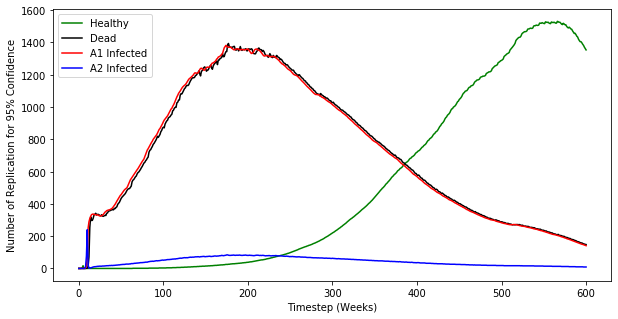

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.xlabel("Timestep (Weeks)")
plt.ylabel("Number of Replication for 95% Confidence")

plt.plot(range(601), results_H, color='g', label='Healthy')
plt.plot(range(601), results_D, color='k', label='Dead')
plt.plot(range(601), results_A1, color='r', label='A1 Infected')
plt.plot(range(601), results_A2, color='b', label='A2 Infected')

plt.legend()

plt.savefig('Replications.png')

In [27]:
replications = max(max(results_H), max(results_A1), max(results_A2), max(results_D))
print(replications)

[1531.]


This graph shows us that we want to run the model ~1600 times ___(1531 to be specfic)___.<br>
We want our graph generate from 739 values to look the same as the graph of cell counts generated in dos Santos' original implementation of this HIV model.<br><br>

___What follows is dos Santos' graph of cell counts across time.___

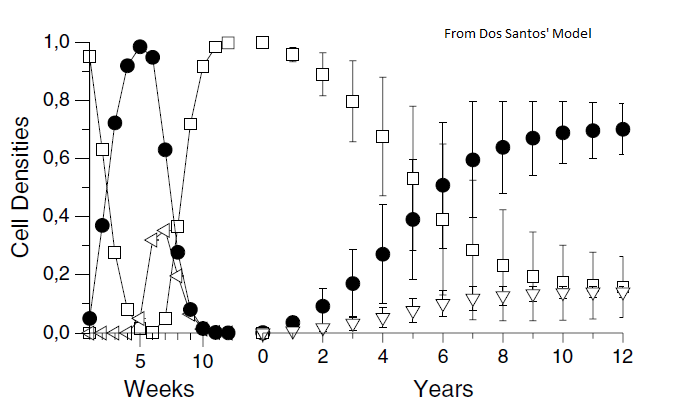

In [26]:
from IPython.display import Image
Image("dossantosOriginal.png")

In [30]:
# once again, we'll time these
from time import time
start = time()

f_out = open('data.csv','w')

# for the purposes of this section, A1 and A2 cells will be combined into one class
for i in range(600):
    f_out.write('H_{0},A_{0},D_{0},'.format(i))
# fencepost solution
f_out.write('H_{0},A_{0},D_{0}\n'.format(600))

# notice the number of replications we found above, which is the number of required simulations we need to verify this model
for i in range(int(replications)):
    counts = CA_SIM(700)
    for j in range(600):
        h,a1,a2,d = counts[j]
        f_out.write('{},{},{},'.format(h,a1+a2,d))
    
    # fencepost solution
    h,a1,a2,d = counts[600]
    f_out.write('{},{},{}\n'.format(h,a1+a2,d))
    

f_out.close()
print('{} seconds elapsed!'.format(time() - start))

458.2876310348511 seconds elapsed!


In [31]:
# first let's get the data we collected
import pandas as pd

data = pd.read_csv('data.csv')

results_H = np.zeros((601,2))
results_A = np.zeros((601,2))
results_D = np.zeros((601,2))

for i in range(601):
    h_std = data['H_{}'.format(i)].std()
    h_mean = data['H_{}'.format(i)].mean()
    results_H[i,0] = h_mean
    results_H[i,1] = h_std
    
    a_std = data['A_{}'.format(i)].std()
    a_mean = data['A_{}'.format(i)].mean()
    results_A[i,0] = a_mean
    results_A[i,1] = a_std

    d_std = data['D_{}'.format(i)].std()
    d_mean = data['D_{}'.format(i)].mean()
    results_D[i,0] = d_mean
    results_D[i,1] = d_std

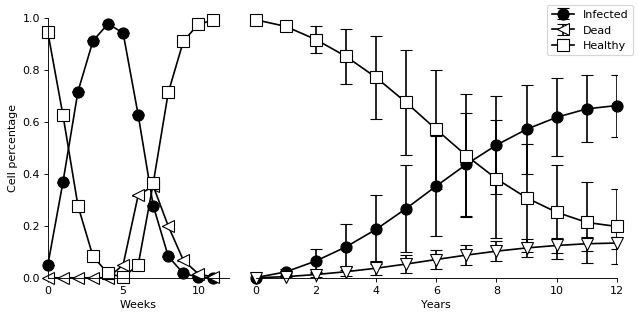

In [32]:
# THIS IS NOT MY CODE

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, sharey=True,
                       gridspec_kw = {'width_ratios':[1, 2]},
                       figsize=(8,4), dpi=80)

yscale = 700**2
xscale = np.arange(0,12)

ax[0].set_xlabel("Weeks")
ax[0].set_ylabel("Cell percentage")
ax[0].errorbar(xscale, results_A[:12,0] / yscale, results_A[:12,1] / yscale, marker='o', clip_on=False, markersize=10, capsize=5, color='k', label='Infected')
ax[0].errorbar(xscale, results_D[:12,0] / yscale, results_D[:12,1] / yscale, marker='<', clip_on=False, markersize=10, capsize=5, color='k', markerfacecolor='white', label='Dead')
ax[0].errorbar(xscale, results_H[:12,0] / yscale, results_H[:12,1] / yscale, marker='s', clip_on=False, markersize=10, capsize=5, color='k', markerfacecolor='white', label='Healthy')
ax[0].axis([0, 12, 0, 1])
ax[0].xaxis.set_ticks(np.arange(0,12,5))

indices = [12] + list(range(52,601,52)) + [-1]
xscale = np.arange(0,13)

ax[1].set_xlabel("Years")
ax[1].errorbar(xscale, results_A[indices,0] / yscale, results_A[indices,1] / yscale, marker='o', clip_on=False, markersize=10, capsize=5, color='k')
ax[1].errorbar(xscale, results_D[indices,0] / yscale, results_D[indices,1] / yscale, marker='v', clip_on=False, markersize=10, capsize=5, color='k', markerfacecolor='white')
ax[1].errorbar(xscale, results_H[indices,0] / yscale, results_H[indices,1] / yscale, marker='s', clip_on=False, markersize=10, capsize=5, color='k', markerfacecolor='white')
ax[1].axis([0, 12, 0, 1])
ax[1].yaxis.set_visible(False)

for i in range(2):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
ax[1].spines['left'].set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
fig.legend()

fig.savefig("dosSantosReplicate.png")

As predicted, the optimized implementation of the model reflects that of the dos Santos' work almost perfectly!

### 2. Image Verification
Now, to verify that we are properly implementing the model in terms of the images, we will create two animations of two different runs from the optimized models. Those are located within the Git, in the Milestone 4/Animations folder.